# Build extent-clipped (tile, basin, etc) stacks
#### used to tally and report biomass within masks (zones); eg. for landcovers
after building the extent-clipped stacks, analyze with extent_report.ipynb

In [2]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
#!pip install s3fs --upgrade
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
import s3fs
s3 = s3fs.S3FileSystem(anon=True)

In [3]:
try:
    import geopandas as gpd
    !pip install -U plotnine
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

import matplotlib
import geopandas as gpd
import pandas as pd
import rasterio
import glob
import os
#import rioxarray
import fiona
from pyproj import CRS, Transformer

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma
from build_stack import *

from plotnine import *
import contextily as ctx
print("Importing packages complete.")
    
font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

NASA MAAP
Importing packages complete.


## Set up output directories, covars footprint vector, and tiles vector input

In [4]:
INDIR_MAIN = '/projects/shared-buckets/nathanmthomas/analyze_agb'
# a writable outdir
OUTDIR_MAIN = '/projects/my-public-bucket/databank/boreal_agb_fires'
!mkdir -p $OUTDIR_MAIN
OUTDIR_CLIPS = os.path.join(OUTDIR_MAIN, 'output/build_stack_fire_clips')
!mkdir -p $OUTDIR_CLIPS

# Setup access to ESA Worldcover s3 rasters
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# ESA Worldcover v100 2020
COVAR_FOOTPRINTS_FN = os.path.join(INDIR_MAIN,'footprints_v100_2020_v100_2020_map-s3.gpkg')

# Get boreal tiles to use CRS for reprojecting HYDROBASINS
boreal_tiles = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg')

https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask

##### Example: Get Worldcover covariate tiles

In [5]:
# Build a VRT of the LC on s3?
covar_footprint_tiles = gpd.read_file(COVAR_FOOTPRINTS_FN)
#covar_footprint_tiles.head()

### Establish some broad DOMAIN in which to collect regions

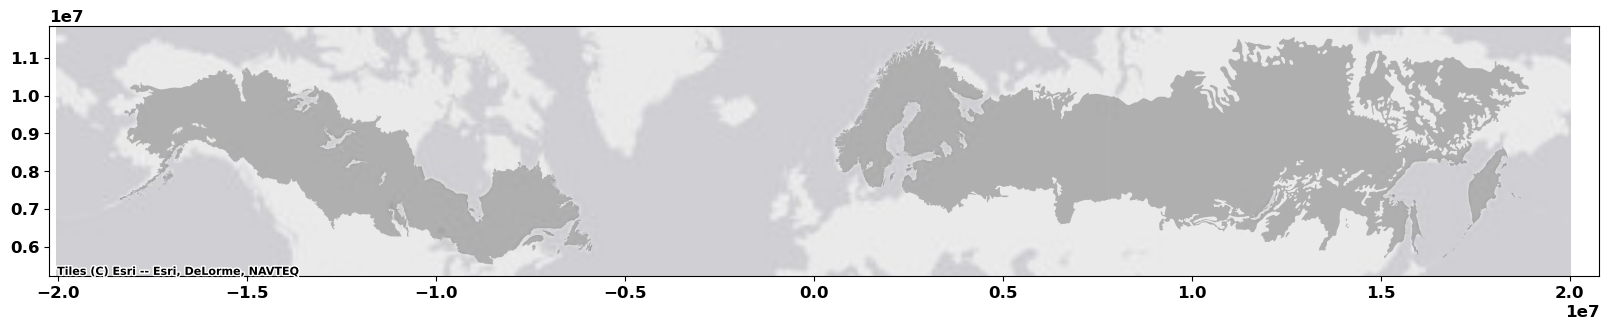

In [6]:
if False:
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
    alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
    canada = world[world.name == 'Canada']
    canada_alaska = pd.concat([alaska, canada])
    canada_alaska.plot()
    
# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', figsize=(20,5))
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by broad domain (boreal)
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

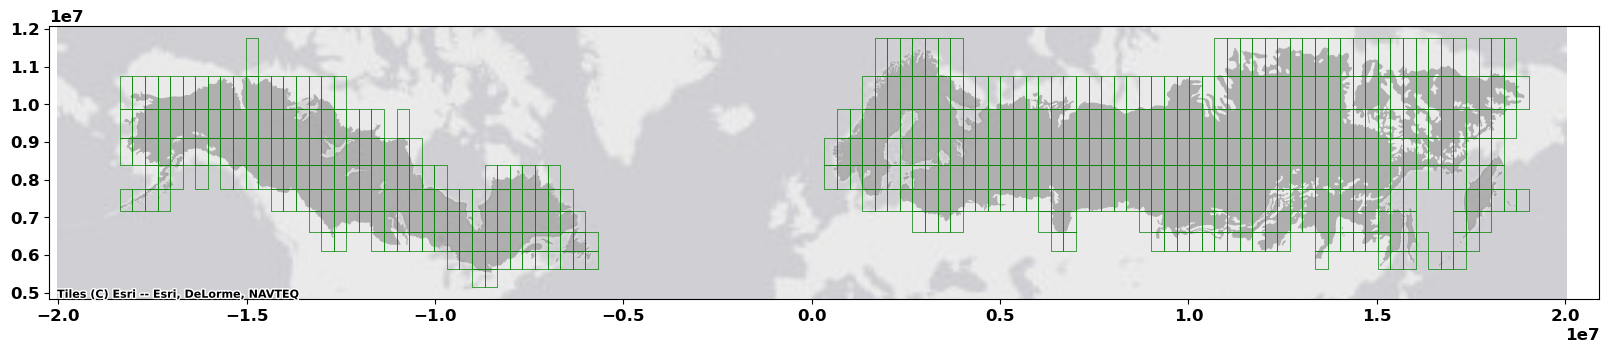

In [7]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles.intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
covar_footprint_tiles_subset = covar_footprint_tiles[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by sub-domain (eg, NA boreal)

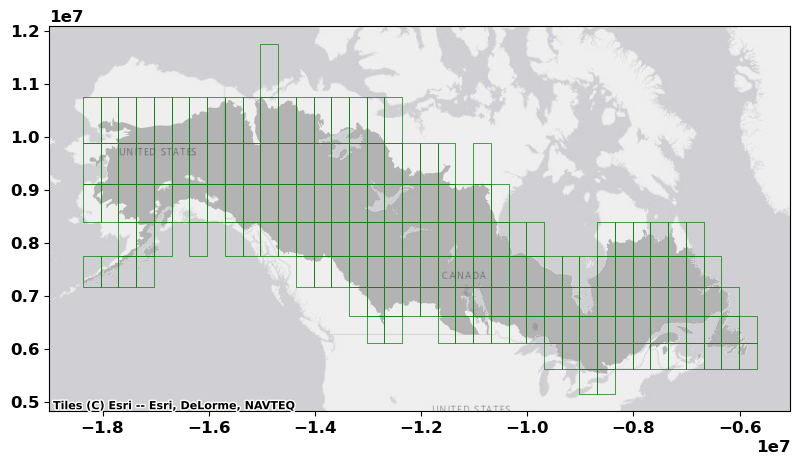

In [8]:
SUB_DOMAIN = 'america' #eurasia

tile_group_region_string = tile_group_region_string + '_' + SUB_DOMAIN

if 'america' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-179, -50, 30, 90]
if 'eurasia' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-20, 179, 30, 90]

SUB_DOMAIN_selection_geometry = boreal_gdf.cx[xmin:xmax, ymin:ymax].iloc[0].geometry

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles_subset.intersects(SUB_DOMAIN_selection_geometry)

covar_footprint_tiles_subset = covar_footprint_tiles_subset[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.cx[xmin:xmax, ymin:ymax].to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

In [9]:
# cog bands dict
bands_dict = {'1': 'esa_worldcover_v100_2020'
             }

### Subset to a focal tile
this is just one of many vector files you can clip by - just requires some prep

In [10]:
FOCAL_TILE = 2686

In [11]:
FIRES_FN = '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.parquet'
FIRES_FN

In [12]:
# import fiona
# fiona.listlayers(FIRES_FN)

### Get fires intersecting focal tile

In [13]:
fires_gdf = gpd.read_parquet(FIRES_FN)

In [99]:
fires_tile = gpd.sjoin(fires_gdf.reset_index().to_crs(boreal_tiles.crs), boreal_tiles[boreal_tiles.tile_num == FOCAL_TILE], predicate='intersects')
fires_tile.set_crs(boreal_tiles.crs)

,level_0,index,fid,id,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,...,lc_type,x,y,layer,geometry,index_right,tile_num,tile_version,tile_group,map_version
1059931,1059931,1059931,2932,5222,2002-06-27,178.0,6.0,2002.0,2002-07-08,12.0,...,None,NaN,NaN,Canada,"POLYGON ((3433653.283 3871319.388, 3433652.271...",2684,2686,version 1,north america centra,none
1062710,1062710,1062710,4047,6786,2002-07-11,192.0,7.0,2002.0,2002-07-19,9.0,...,None,NaN,NaN,Canada,"POLYGON ((3439596.188 3932692.233, 3439595.200...",2684,2686,version 1,north america centra,none
1062986,1062986,1062986,3779,6423,2002-07-08,189.0,7.0,2002.0,2002-07-08,1.0,...,None,NaN,NaN,Canada,"POLYGON ((3430115.234 3870887.662, 3429326.533...",2684,2686,version 1,north america centra,none
1067006,1067006,1067006,7927,15613,2003-08-10,222.0,8.0,2003.0,2003-08-10,1.0,...,None,NaN,NaN,Canada,"POLYGON ((3460944.762 3896387.541, 3461723.471...",2684,2686,version 1,north america centra,none
1067087,1067087,1067087,8040,15860,2003-08-12,224.0,8.0,2003.0,2003-08-15,4.0,...,None,NaN,NaN,Canada,"POLYGON ((3460687.149 3898747.644, 3461465.611...",2684,2686,version 1,north america centra,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209786,1209786,1209786,87550,178956,2021-07-31,212.0,7.0,2021.0,2021-07-31,1.0,...,None,NaN,NaN,Canada,"POLYGON ((3433636.696 3889753.652, 3432850.611...",2684,2686,version 1,north america centra,none
1210041,1210041,1210041,87293,178675,2021-07-30,211.0,7.0,2021.0,2021-07-30,1.0,...,None,NaN,NaN,Canada,"POLYGON ((3433024.621 3897988.836, 3432239.439...",2684,2686,version 1,north america centra,none
1210046,1210046,1210046,87298,178681,2021-07-30,211.0,7.0,2021.0,2021-07-30,1.0,...,None,NaN,NaN,Canada,"POLYGON ((3431376.943 3897967.624, 3432158.803...",2684,2686,version 1,north america centra,none
1210077,1210077,1210077,87201,178575,2021-07-29,210.0,7.0,2021.0,2021-07-29,1.0,...,None,NaN,NaN,Canada,"POLYGON ((3457487.442 3856230.931, 3456700.175...",2684,2686,version 1,north america centra,none


### Establish and CHOOSE the clip INDEX_FN
vector polygon regions (specific basin, LVIS flightline, tile, etc within sub-domain)
* the GPKG that holds 1 specific clip polygon

In [80]:
CLIP_INDEX_DICT_LIST = [
    # Hydrobasins
    {
        'ID_COL_NAME': 'index',
        'ID': None,#7060157640, #3060534340, #7060157640 4070084980 #4070000010,
        'ID_NAME': 'layer',
        'INDEX_LYR': None,
        'INDEX_FN': FIRES_FN, #f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
        'ADD_STR': f'_{FOCAL_TILE}_reprj',
        'INDEX_REPRJ_FN': FIRES_FN.replace('.parquet', f'_{FOCAL_TILE}_reprj' + '.gpkg')
    }
]

# Choose SPECIFIC dictionary with clip index vector (AOI) info

In [81]:
CLIP_INDEX_DICT = CLIP_INDEX_DICT_LIST[0]
CLIP_INDEX_DICT

{'ID_COL_NAME': 'index',
 'ID': None,
 'ID_NAME': 'layer',
 'INDEX_LYR': None,
 'INDEX_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.parquet',
 'ADD_STR': '_2686_reprj',
 'INDEX_REPRJ_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal_2686_reprj.gpkg'}

### Read and subset the clipping INDEX vector
update string variables used in BUILD_STACK

In [82]:
CLIP_INDEX_DICT

{'ID_COL_NAME': 'index',
 'ID': None,
 'ID_NAME': 'layer',
 'INDEX_LYR': None,
 'INDEX_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.parquet',
 'ADD_STR': '_2686_reprj',
 'INDEX_REPRJ_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal_2686_reprj.gpkg'}

In [77]:
MIN_SZ_sqkm = 0.5

In [98]:
fires_tile.crs

<Bound CRS: PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DAT ...>
Name: unnamed
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from GRS 1980(IUGG, 1980) to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: unknown
- Ellipsoid: GRS80
- Prime Meridian: Greenwich
Source CRS: unnamed

In [101]:
POLY_GDF = fires_tile[(fires_tile.tot_ar_km2 >= MIN_SZ_sqkm)].set_crs(boreal_tiles.crs)

In [102]:
POLY_GDF.to_file(CLIP_INDEX_DICT['INDEX_REPRJ_FN'], driver='GPKG')

<Axes: >

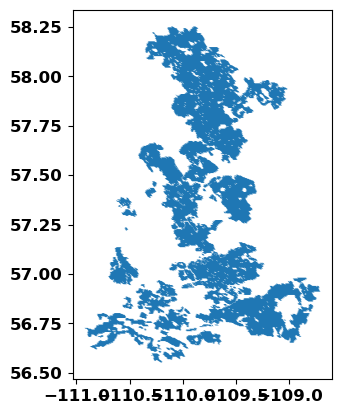

In [103]:
POLY_GDF.to_crs(4326).plot()

In [83]:
INDEX_FN = CLIP_INDEX_DICT['INDEX_REPRJ_FN']

# The INDEX_LYR comes off the INDEX_FN set just above...
if CLIP_INDEX_DICT['INDEX_LYR'] is None:
    print('Specify the layer name of the GPKG...')
    INDEX_LYR = os.path.split(INDEX_FN)[1].split('.gpkg')[0]
else:
    INDEX_LYR = CLIP_INDEX_DICT['INDEX_LYR']

print(f"\nDone updating file string input for build_stack():\n{INDEX_FN}\n{INDEX_LYR}")

Specify the layer name of the GPKG...

Done updating file string input for build_stack():
/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal_2686_reprj.gpkg
firedpy_boreal_2686_reprj


### Get clip extent: all fires > threshold that intersect focal tile

In [111]:
POLY_GDF.sort_values('tot_ar_km2', inplace=True)

In [112]:
print(POLY_GDF.index.to_list())
#print(POLY_GDF.index.to_list())

[1080484, 1099294, 1099499, 1095012, 1185296, 1099871, 1099875, 1067006, 1099931, 1099934, 1099943, 1208136, 1099732, 1099685, 1080013, 1077377, 1099549, 1099877, 1101524, 1099832, 1207787, 1099957, 1207918, 1080259, 1099299, 1181585, 1187121, 1099295, 1186938, 1186988, 1094986, 1195004, 1072556, 1067294, 1099586, 1101528, 1099630, 1187354, 1099864, 1099598, 1079576, 1099694, 1208152, 1187020, 1195005, 1079578, 1073221, 1087065, 1099700, 1101542, 1079622, 1101556, 1206214, 1196226, 1080685, 1195031, 1073050, 1181577, 1098259, 1080532, 1187074, 1098281, 1186978, 1181563, 1184107, 1099495, 1099546, 1095120, 1187355, 1188089, 1100175, 1072775, 1062710, 1187323, 1067671, 1087105, 1205119, 1186992, 1095283, 1059931, 1099815, 1205310, 1186989, 1187378, 1091567, 1205759, 1183479, 1094892, 1187007, 1080547, 1186966, 1080606, 1205392, 1187431, 1076109, 1080838, 1100174, 1184073, 1081240]


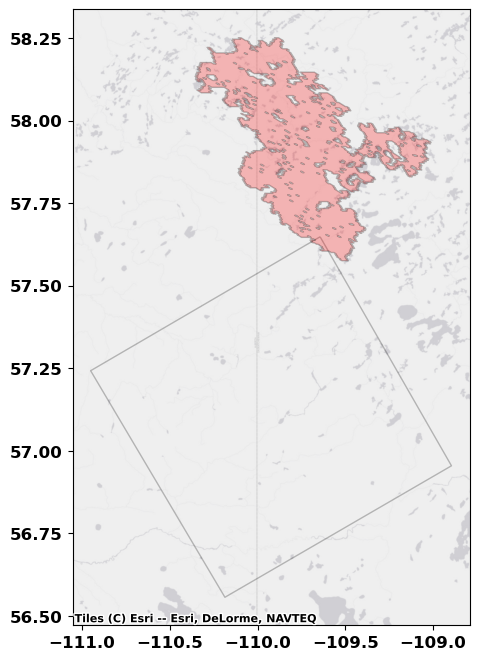

In [114]:
ID_COL_NAME = CLIP_INDEX_DICT['ID_COL_NAME']
ax = boreal_tiles[boreal_tiles.tile_num == FOCAL_TILE].to_crs(4326).plot(facecolor='none', alpha=0.25, ec='k', figsize=(12,8))
ax = POLY_GDF.tail(1).to_crs(4326).plot(ax=ax, color='red', alpha=0.25, ec='k')
ax = ctx.add_basemap(ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, zoom=10)

#### Plot clip extent within boreal 
This will fail if the TILE_NUM specified is NOT in the data frame

# Set list of dictionary inputs to stack
## Setup input using hydrobasin as clip INDEX_FN
* reprojected to equal area using boreal_tile_index
* so output has same res, crs, and clip extent

In [85]:
from mosaiclib import *

In [128]:
[print(var) for var in locals() if 'JSON' in var]
AGB_MOSAIC_JSON_FN_DICT

AGB_MOSAIC_JSON_FN_DICT
HT_MOSAIC_JSON_FN_DICT
HLS_MOSAIC_JSON_FN_DICT
SAR_MOSAIC_JSON_FN_DICT
LC_MOSAIC_JSON_FN_DICT
TOPO_MOSAIC_JSON_FN_DICT


{'c2020_v1.0': '',
 '2019_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2019/2019_fullboreal_2019lidar/AGB_tindex_master_mosaic.json',
 '2020_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2020/atl08_v6_fullboreal_min5000_90p_local/AGB_tindex_master_mosaic.json',
 '2021_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/AGB_tindex_master_mosaic.json',
 '2022_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2022/2022_fullboreal_2022lidar/AGB_tindex_master_mosaic.json',
 '2023_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2023/2023_full_2023lidar/AGB_tindex_master_mosaic.json',
 '2020_v2.0': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/V

In [135]:
#BUILD_STACK_DICT = {'INDEX_FN':INDEX_FN,'ID_COL_NAME':ID_COL_NAME,'TILE_NUM':TILE_NUM,'INDEX_LYR':INDEX_LYR,'RASTER_NAME':'','COVAR_TILE_FN':'', 'IN_COVAR_S3_COL':'', 'NODATA_VAL':''}
DEFAULT_BUILD_STACK_DICT_LIST = [
    # # ESA Worldcover 2020
    #     {
    #         'INDEX_FN':INDEX_FN,
    #         'ID_COL_NAME':ID_COL_NAME,
    #         'TILE_NUM':TILE_NUM,
    #         'INDEX_LYR':INDEX_LYR,
    #         # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
    #         'RASTER_NAME': 'esa_worldcover_v100_2020',
    #         'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_v100_2020_v100_2020_map-s3.gpkg',
    #         'IN_COVAR_S3_COL': 's3_path',
    #         'NODATA_VAL': 0,
    #         'OUTPUT_CLIP_COG_FN':'',
    #         'CREDENTIALS_FN': None
    #     },
        # # Boreal Biomass c2020 (final)
        # {
        #     'INDEX_FN':INDEX_FN,
        #     'ID_COL_NAME':ID_COL_NAME,
        #     'TILE_NUM':TILE_NUM,
        #     'INDEX_LYR':INDEX_LYR,
        #     # AGB data is accessed
        #     # This needs to be correctly in 4326 - 
        #     'RASTER_NAME': 'biomass_final',
        #     'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json',
        #     'IN_COVAR_S3_COL': 's3_path',
        #     'NODATA_VAL': -9999,
        #     'OUTPUT_CLIP_COG_FN':'',
        #     'CREDENTIALS_FN': None
        # },
# Boreal Biomass 2020 (v2)
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'biomass_v2',
            'COVAR_TILE_FN': AGB_TINDEX_FN_DICT['2020_v2.0'].replace('.csv','.gpkg'),
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
    # # Boreal Stand Age 2020
    #     {
    #         'INDEX_FN':INDEX_FN,
    #         'ID_COL_NAME':ID_COL_NAME,
    #         'TILE_NUM':TILE_NUM,
    #         'INDEX_LYR':INDEX_LYR,
    #         # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
    #         'RASTER_NAME': 'standage',
    #         'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_forest_age_v2-s3.gpkg',
    #         'IN_COVAR_S3_COL': 's3_path',
    #         'NODATA_VAL': 255,
    #         'OUTPUT_CLIP_COG_FN':'',
    #         'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
    #     },
    # Boreal TCC 2020
        # {
        #     'INDEX_FN':INDEX_FN,
        #     'ID_COL_NAME':ID_COL_NAME,
        #     'TILE_NUM':TILE_NUM,
        #     'INDEX_LYR':INDEX_LYR,
        #     # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
        #     'RASTER_NAME': 'tcc2020',
        #     'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_tcc_2020-s3.gpkg',
        #     'IN_COVAR_S3_COL': 's3_path',
        #     'NODATA_VAL': 255,
        #     'OUTPUT_CLIP_COG_FN':'',
        #     'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        # },
    # Boreal TCC rate of change (linear), 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccslope',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        },
    # Boreal TCC rate of change (linear) p-value, 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccpvalue',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_tcc_pvalue-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        }
]

DEFAULT_BUILD_STACK_DICT_LIST

[{'INDEX_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal_2686_reprj.gpkg',
  'ID_COL_NAME': 'index',
  'TILE_NUM': 1079622,
  'INDEX_LYR': 'firedpy_boreal_2686_reprj',
  'RASTER_NAME': 'biomass_v2',
  'COVAR_TILE_FN': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': -9999,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': None},
 {'INDEX_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal_2686_reprj.gpkg',
  'ID_COL_NAME': 'index',
  'TILE_NUM': 1079622,
  'INDEX_LYR': 'firedpy_boreal_2686_reprj',
  'RASTER_NAME': 'tccslope',
  'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 255,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'},
 {'INDEX_FN': '/

# Choose layers for stack

In [136]:
BUILD_STACK_DICT_LIST = DEFAULT_BUILD_STACK_DICT_LIST
BUILD_STACK_DICT_LIST

[{'INDEX_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal_2686_reprj.gpkg',
  'ID_COL_NAME': 'index',
  'TILE_NUM': 1079622,
  'INDEX_LYR': 'firedpy_boreal_2686_reprj',
  'RASTER_NAME': 'biomass_v2',
  'COVAR_TILE_FN': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': -9999,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': None},
 {'INDEX_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal_2686_reprj.gpkg',
  'ID_COL_NAME': 'index',
  'TILE_NUM': 1079622,
  'INDEX_LYR': 'firedpy_boreal_2686_reprj',
  'RASTER_NAME': 'tccslope',
  'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 255,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'},
 {'INDEX_FN': '/

## Run the extent clips of the rasters
#### Get the list of IDs

In [131]:
FIRE_ID_LIST = POLY_GDF.index.to_list()

In [132]:
BUILD_STACK_DICT_LIST[0]['COVAR_TILE_FN']

's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master_mosaic.json'

In [123]:
z = gpd.read_file(BUILD_STACK_DICT_LIST[0]['INDEX_FN']).to_crs(4326)

<Axes: >

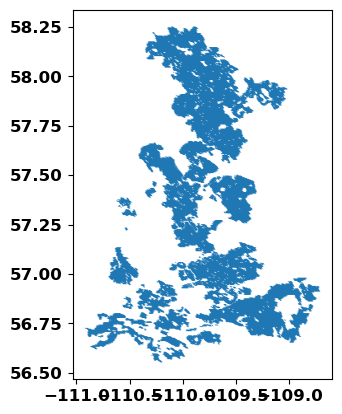

In [124]:
z.plot()

In [92]:
from multiprocessing import Pool
from functools import partial

In [139]:
def multi_process_build_stack(ID, BUILD_STACK_DICT=BUILD_STACK_DICT_LIST[0], OUTDIR_CLIPS=OUTDIR_CLIPS):
    
    BUILD_STACK_DICT.update([('TILE_NUM', ID)])
    BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN'] = os.path.join( OUTDIR_CLIPS, f"{BUILD_STACK_DICT['RASTER_NAME']}_{BUILD_STACK_DICT['TILE_NUM']}_cog.tif")
    
    # # INDEX clip shapes should be in equal area
    # # COVAR_TILE_FN tiles (of raster COGs) should be in 4326
    # args = f"\
    # --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    # --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    # --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    # --tile_buffer_m 0 \
    # --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    # -o {OUTDIR_CLIPS} \
    # --topo_off \
    # --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    # --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    # --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    # --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    # --clip" #<-- testing a clip to polygon
    # print(args,'\n')
    
    def run_build_stack():
        build_stack_(
            stack_tile_fn = BUILD_STACK_DICT['INDEX_FN'], 
            in_tile_id_col = BUILD_STACK_DICT['ID_COL_NAME'], 
            stack_tile_id = BUILD_STACK_DICT['TILE_NUM'],
            tile_buffer_m = 0, 
            stack_tile_layer = BUILD_STACK_DICT['INDEX_LYR'],
            covar_tile_fn = BUILD_STACK_DICT['COVAR_TILE_FN'],
            in_covar_s3_col = BUILD_STACK_DICT['IN_COVAR_S3_COL'],
            bandnames_list = ['first'],
            band_indexes_list = [1],
            res = 30, 
            input_nodata_value = BUILD_STACK_DICT['NODATA_VAL'],
            tmp_out_path = '/projects/tmp', 
            covar_src_name = BUILD_STACK_DICT['RASTER_NAME'],
            clip = True, 
            topo_off = True, 
            output_dir = OUTDIR_CLIPS,
            height = None,
            width = None
           )
    if True:
        # Try without setting up an aws_session
        run_build_stack()
    else:
        if BUILD_STACK_DICT['CREDENTIALS_FN'] is not None:
            aws_session = CovariateUtils.get_rio_aws_session_from_creds(BUILD_STACK_DICT['CREDENTIALS_FN'])
            with rio.Env(aws_session):
                #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
                run_build_stack()
        else:
            #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
            run_build_stack()

In [183]:
with Pool(processes=5) as pool:
    returned_stuff = pool.map(partial(multi_process_build_stack, BUILD_STACK_DICT = BUILD_STACK_DICT_LIST[0], OUTDIR_CLIPS = OUTDIR_CLIPS ), FIRE_ID_LIST[-1:])

4 covariate filename(s) intersecting the 0 m buffered bbox for tile id 1081240:

Getting output height and width from buffered (buffer=0) original poly geometry...
in_bbox: [3353408.222513922, 3920509.934071156, 3440148.5386757995, 3981482.5012376737]
2032 x 2891
Band indexes list: [1]
['first']
s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/2024/07/17/15/41/19/123400/boreal_agb_202407171721255968_002606.tif
s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/2024/07/17/15/52/45/888264/boreal_agb_202407171721256657_002686.tif
s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/2024/07/17/16/27/44/837215/boreal_agb_202407171721258749_002685.tif
s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/2024/07/17/17/18/27/279504/boreal_agb_202407171

/projects/code/icesat2_boreal/lib/build_stack.py:431: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.


Current stack shape:		(1,2892,2033)


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/fdf583dd-ea3c-449f-8ebb-d6979c39a2c2/fdf583dd-ea3c-449f-8ebb-d6979c39a2c2.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/databank/boreal_agb_fires/output/build_stack_fire_clips/biomass_v2_1081240_cog.tif


Image written to disk:		 /projects/my-public-bucket/databank/boreal_agb_fires/output/build_stack_fire_clips/biomass_v2_1081240_cog.tif
Removing tmp file: biomass_v2_1081240_cog.tif.msk


In [182]:
FIRE_ID_LIST[-1:]

[1081240]

In [187]:
POLY_GDF.iloc[-1]

level_0                                                   1081240
index                                                     1081240
fid                                                         22577
id                                                          50502
ig_date                                                2006-06-02
ig_day                                                      153.0
ig_month                                                      6.0
ig_year                                                    2006.0
last_date                                              2006-07-17
event_dur                                                    46.0
tot_pix                                                   10209.0
tot_ar_km2                                            2191.450396
fsr_px_dy                                              221.934783
fsr_km2_dy                                              47.640226
mx_grw_px                                                  2283.0
mn_grw_px 

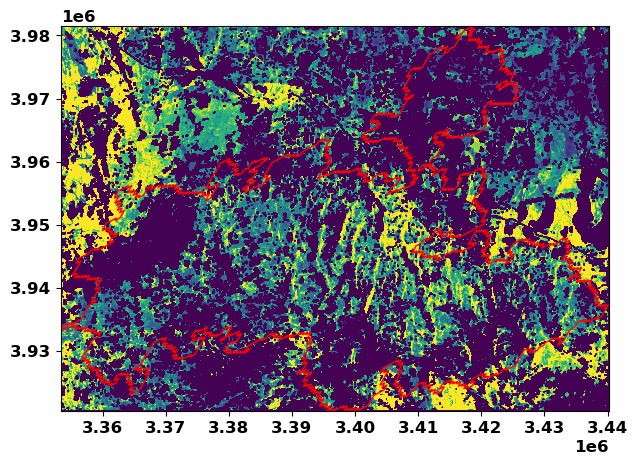

In [186]:
fig,(ax1)=plt.subplots(1,1,figsize=(10,5))

with rasterio.open('/projects/my-public-bucket/databank/boreal_agb_fires/output/build_stack_fire_clips/biomass_v2_1081240_cog.tif') as src:
    
    show(src.read(), transform=src.transform, ax=ax1, vmin=0, vmax=15, alpha=1)
    xs, ys = POLY_GDF[POLY_GDF.index == 1081240].iloc[0].geometry.exterior.xy
    ax1.fill(xs, ys, alpha=1, ec='r', fc='none')
    
    plt.show()

In [76]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.6 MB/s eta 0:00:00a 0:00:01


In [95]:
def rename_columns(GDF, bandname, stats_list):
    if stats_list is not None:
       
        names_list = ['val_'+ bandname + '_' + s for s in stats_list]
        rename_dict = dict(zip(stats_list, names_list))      
        GDF = GDF.rename(columns = rename_dict)
        
    return GDF

def extract_zonal_gdf_poly(HYBAS_ID, bandnames: list, GDF_fn = OUT_HYBAS_NORTHERN_FN, ndval=255, 
                           stats_list = ['max','min','median','mean','percentile_02','percentile_25','percentile_75','percentile_98','count']):
    
    r_fn = f'/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_{HYBAS_ID}_cog.tif'
    GDF = gpd.read_file(GDF_fn)
    GDF = GDF[GDF.HYBAS_ID == HYBAS_ID]
    
    from rasterstats import zonal_stats
    import numpy as np
    
    gdf_list = []
    
    with rasterio.open(r_fn) as r_src:
        print("\tExtracting raster values from: ", r_fn)

        for i, bandname in enumerate(bandnames):
            
            bnum = i + 1
            print(bnum)
            
            # Get array
            array = r_src.read(bnum)
            array = array.astype('float64')
            array[array==ndval] = np.nan
            df = pd.DataFrame(
                    zonal_stats(
                        vectors=GDF.to_crs(r_src.crs), 
                        raster= array,#r_src.read(bnum, masked=True),
                        affine= r_src.transform,
                        stats=stats_list
                    )
            )

            # Rename cols
            df = rename_columns(df, bandname, stats_list)

            final_gdf = GDF.reset_index().join(df.reset_index(drop=True), how='left')
            gdf_list.append(final_gdf)
            
        # Write the table of zonal stats on each band for current HYBAS_ID   
        hybas_id_gdf = pd.concat(gdf_list)
        hybas_id_gdf.to_file(r_fn.split('.tif')[0] + '_zonalstats.gpkg', driver = 'GPKG')
    
    return pd.concat(gdf_list)

# z = extract_zonal_gdf_poly(r_fn, GDF[GDF.HYBAS_ID == HYBAS_ID].iloc[[0]], bandnames=['tcc_slope'], reproject=False)
# z

In [97]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(extract_zonal_gdf_poly, bandnames = ['tccslope'], GDF_fn = OUT_HYBAS_NORTHERN_FN ), ['8080279620', '8080285990', '8080276800', '8080269420'])

	Extracting raster values from:  /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080285990_cog.tif
1


/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly


	Extracting raster values from: 	Extracting raster values from:   /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080279620_cog.tif/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080269420_cog.tif

11



/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly


	Extracting raster values from:  /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080276800_cog.tif
1


/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly


In [98]:
pd.concat(returned_stuff)

,index,HYBAS_ID,pattern_class,geometry,val_tccslope_min,val_tccslope_max,val_tccslope_mean,val_tccslope_count,val_tccslope_median,val_tccslope_percentile_02,val_tccslope_percentile_25,val_tccslope_percentile_75,val_tccslope_percentile_98
0,2201,8080279620,TTE diffuse,"POLYGON ((-128.88506 60.80869, -128.86284 60.8...",1.036452e-28,1.000000,0.405231,1478880,1.386249e-01,7.978080e-12,3.275628e-04,1.000000e+00,1.000000
1,12634,8080279620,boreal,"MULTIPOLYGON (((-128.19388 60.59527, -128.2019...",1.179616e-06,1.000000,0.259238,18,1.194037e-01,1.253070e-06,3.055857e-02,2.366298e-01,1.000000
0,2202,8080285990,TTE diffuse,"POLYGON ((-129.42918 60.62915, -129.42693 60.6...",2.800274e-26,1.000000,0.412777,2385876,1.387852e-01,2.849146e-11,1.106067e-03,1.000000e+00,1.000000
1,12621,8080285990,boreal,"MULTIPOLYGON (((-128.75000 60.42500, -128.7492...",6.961336e-13,1.000000,0.436482,32,2.517003e-01,3.025609e-11,3.540624e-05,1.000000e+00,1.000000
0,2203,8080276800,TTE diffuse,"POLYGON ((-128.12882 61.11075, -128.12536 61.1...",2.452631e-26,1.000000,0.297070,1037711,6.632142e-02,2.866466e-09,1.756197e-03,5.746593e-01,1.000000
1,12542,8080276800,boreal,"MULTIPOLYGON (((-127.69223 60.74779, -127.6922...",1.064217e-06,0.231149,0.057845,4,1.156741e-04,1.119720e-06,1.758004e-06,5.795915e-02,0.217293
0,2204,8080269420,TTE diffuse,"POLYGON ((-125.47563 61.13117, -125.47500 61.1...",1.072597e-29,1.000000,0.023193,195720,2.905809e-11,7.872767e-21,2.045506e-14,7.265951e-08,0.522382
1,11768,8080269420,boreal,"MULTIPOLYGON (((-125.20417 61.10000, -125.2041...",3.942438e-07,1.000000,0.252414,4,4.826999e-03,4.765719e-06,5.503769e-05,2.571856e-01,0.940575


In [40]:
# For each clip INDEX (polygon) there are 2 corresponding output clipped COGs you need
BASIN_COG_DICT = {'landcover_cog_fn': '', 'biomass_cog_fn':'', 'standage_cog_fn':'', 'extent_gdf_fn': extent_gdf_fn}

for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    if 'worldcover' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'landcover_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'biomass' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'biomass_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'standage' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'standage_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tcc2020' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tcc2020_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tccslope' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tccslope_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tccpvalue' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tccpvalue_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
BASIN_COG_DICT

NameError: name 'extent_gdf_fn' is not defined